In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer


In [2]:
#Using sqllite to fetch the data
con=sqlite3.connect('C:\\Users\\RAJAN SHRIVASTAVA\\Documents\\AppliedAI\\ML Algorithms\\database.sqlite')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data=pd.read_sql_query(""" select * from Reviews where Score !=3""",con)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

actualscore=filtered_data['Score']
positiveNegative=actualscore.map(partition)
filtered_data['Score']=positiveNegative

In [3]:
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
display=pd.read_sql_query(""" select * from Reviews where HelpfulnessNumerator > HelpfulnessDenominator """,con)

In [5]:
display=pd.read_sql_query(""" select * from Reviews where Score !=3 and UserId='AR5J8UI46CURR' """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Sorting the data according to the productId
sort_data=filtered_data.sort_values('ProductId',ascending=True,axis=0,inplace=False,kind='quicksort',na_position='last')

final_data=sort_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [7]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [8]:
final_data.shape

(364171, 10)

# I am going to take 20000 Samples as I am having Low config pc

In [9]:
final_data=final_data.sample(n=20000,replace=True)

# Time Based Slicing

In [10]:
final_data=final_data.sort_values('Time',ascending=True)

In [11]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
346077,374382,B00004CI84,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,1,1014681600,...,"It was on the other night, and, having been a ..."
443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,1,1022112000,Way To Go Guys!,I'm never dissapointed with the great gadgets ...
443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,1,1022112000,Way To Go Guys!,I'm never dissapointed with the great gadgets ...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."


In [12]:
# Find the sentences containing html tag using regular expression 
import re
i=0
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break;
    i=i+1;   

1
It was on the other night, and, having been a big fan of the cartoon when it was being shown, decided to watch it (I'm also trying to see all the Winona Ryder movies I know.). <p> It's a well known fact i like seeing her [Winona Ryder] dance at the end of a movie (hey, it's funny!), but apart from that, it was just a hilarious film and i liked it very much. The only thing  wrong was that it was too short. Maybe the special efects were a bit &quot;off&quot;, but hey, it's an older movie1


In [13]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [14]:
stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')

In [15]:
def cleanhtml(sentences):#function to clean html tag from the word
    cleaner=re.compile('<.*?>')
    cleantext=re.sub(cleaner,'',sentences)
    return cleantext
def cleanpunc(sentences):# function to clean the punctuation from the word
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentences)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('******************************************************************')
print(sno.stem('tasty'))

{'didn', 'ma', 'before', 'why', 'be', 'very', 'it', 'have', 'couldn', 'against', 'should', 'out', 'o', 'this', 'between', 'they', 'down', 'so', 'ours', 'both', 'has', 's', 'are', 'shan', "won't", 'more', 'about', 'was', 'same', 'again', 'had', 'only', 'i', 'and', 'won', 'mustn', 'am', 'how', 'hadn', 'hasn', "didn't", 'below', "hadn't", 'doesn', 'theirs', 'than', 'myself', 'do', "you'll", 'with', 'in', "hasn't", 'my', 'shouldn', 'during', 'each', 'nor', 'is', 't', 'an', 'he', 'your', 'yours', 'doing', 'to', "wouldn't", 'been', "isn't", "mustn't", 'when', 'll', 'through', 'needn', 'its', "she's", 'themselves', 'me', 'them', 'does', 'but', 'just', 'too', 'few', 'whom', 'at', "you've", 'all', 'him', 'yourselves', "shouldn't", "weren't", 'if', "needn't", "that'll", 'up', 'because', 'there', 'from', "should've", "aren't", 'of', 'after', 'or', 'don', 'having', 'we', 'while', 'into', "shan't", 'the', 'his', "doesn't", 'wouldn', 'over', 'above', 're', 'isn', 'who', 'for', 'himself', 'her', 'und

# Bag of Words

In [16]:
count_vec=CountVectorizer()

In [17]:
final_count=count_vec.fit_transform(final_data['Text'].values)

In [18]:
type(final_count)

scipy.sparse.csr.csr_matrix

In [19]:
final_count.shape

(20000, 28600)

In [20]:
reviews=final_data['Score']

In [21]:
reviews=reviews[0:20000]

In [22]:
reviews.shape

(20000,)

In [23]:
final_count.shape

(20000, 28600)

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Now our goal is to find the best k value so that We can feed in our Algorithm

# 10 Fold Cross Validation

In [25]:
#X_1,X_test,Y_1,Y_test=cross_validation.train_test_split(final_count,reviews,test_size=0.3,random_state=0)
#X_train,X_cv,Y_train,Y_cv=cross_validation.train_test_split(X_1,Y_1,test_size=0.3)

In [27]:
tscv=TimeSeriesSplit(n_splits=3)
reviews=reviews.values.reshape(-1,1)
for train_index,test_index in tscv.split(final_count):
    print("Train:", train_index,"Test:", test_index)
    X_train,X_test = final_count[train_index],final_count[test_index]
    Y_train, Y_test = reviews[train_index],reviews[test_index]

Train: [   0    1    2 ..., 4997 4998 4999] Test: [5000 5001 5002 ..., 9997 9998 9999]
Train: [   0    1    2 ..., 9997 9998 9999] Test: [10000 10001 10002 ..., 14997 14998 14999]
Train: [    0     1     2 ..., 14997 14998 14999] Test: [15000 15001 15002 ..., 19997 19998 19999]


In [30]:
tscv=TimeSeriesSplit(n_splits=3)
#reviews=reviews.values.reshape(-1,1)
for CV_index,test1_index in tscv.split(X_test):
    print("Train:", CV_index,"Test:", test1_index)
    X_CV,X_test1 = X_test[CV_index],X_test[test1_index]
    Y_CV, Y_test1 = Y_test[CV_index],Y_test[test1_index]

Train: [   0    1    2 ..., 1247 1248 1249] Test: [1250 1251 1252 ..., 2497 2498 2499]
Train: [   0    1    2 ..., 2497 2498 2499] Test: [2500 2501 2502 ..., 3747 3748 3749]
Train: [   0    1    2 ..., 3747 3748 3749] Test: [3750 3751 3752 ..., 4997 4998 4999]


In [33]:
Y_CV=Y_CV.ravel()


The optimal number of neighbors is 19.


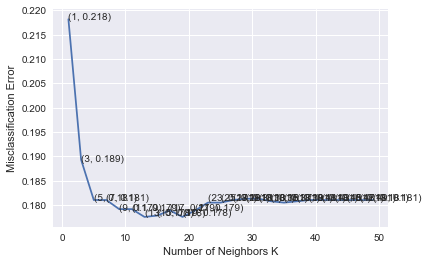

the misclassification error for each k value is :  [ 0.218  0.189  0.181  0.181  0.179  0.179  0.178  0.178  0.179  0.178
  0.179  0.181  0.181  0.181  0.181  0.181  0.181  0.181  0.181  0.181
  0.181  0.181  0.181  0.181  0.181]


In [34]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_CV, Y_CV, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# Observation ---Here We have got a very interesting curve, The MSE is high on the Low value of the K as the K value increases ,our MSE starts decreasing and becomes staturated at k =13

In [36]:
# We have found our optimal K value
Knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
#Fitting the Model
Knn_optimal.fit(X_train,Y_train)
#Predicting the Model
predict=Knn_optimal.predict(X_test1)
#Evaluate accuracy
acc=accuracy_score(Y_test1,predict)*float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 19 is 83.520000%


# Observation---As we have taken 20k Sample from 300k sample , so We might loose some of the information, 83% Accuracy is good but We can't say anything May be it's acuracy is improved better when We use 300K datasets

# Let's check our model with using Brutforce

In [49]:
Knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
#Fitting the Model
Knn_optimal.fit(X_train,Y_train)
#Predicting the Model
predict=Knn_optimal.predict(X_test1)
#Evaluate accuracy
acc=accuracy_score(Y_test1,predict)*float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 19 is 83.520000%


In [50]:
from sklearn.metrics import confusion_matrix,classification_report
cm=metrics.confusion_matrix(Y_test1,predict)

In [51]:
print(cm)

[[   7  203]
 [   3 1037]]


In [53]:
print(classification_report(Y_test1,predict))

             precision    recall  f1-score   support

          0       0.70      0.03      0.06       210
          1       0.84      1.00      0.91      1040

avg / total       0.81      0.84      0.77      1250



# ROC Curve

In [54]:
from sklearn.metrics import roc_curve,auc

In [55]:
fpr,tpr,thresholds=roc_curve(Y_test1,predict)

In [56]:
roc_auc=auc(fpr,tpr)

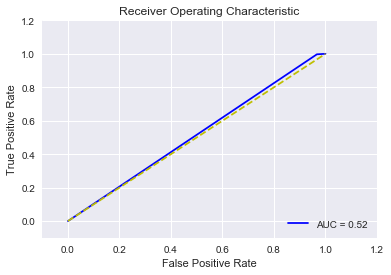

In [57]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
TN=cm[0][0]
FN=cm[0][1]
FP=cm[1][0]
TP=cm[1][1]
P=FN+TP
N=TN+FP

In [59]:
true_positive_rate=TP/P
true_negative_rate=TN/N
false_positive_rate=FP/N
false_negative_rate=FN/P

In [60]:
print('TPR',true_positive_rate,'TNR =',true_negative_rate,'FPR =',false_positive_rate,'FNR =',false_negative_rate)

TPR 0.836290322581 TNR = 0.7 FPR = 0.3 FNR = 0.163709677419


# Observation----Our TP=5026 from confusion matrix , There are the reviews which are positive and our Model is also predicted positive
#TN=56 These are the negative review and Our Model has also predicted negative
##FN=55 These are the positive reviews but our model predicted negative
FP=863 These are negative reviews but predicted positive


# Precision:
    
By looking into classification Report , We have a nice value of the Precision=0.85 , It tells us that Total numner of the predicted positive reviews in which how many are actual positive reviews

# Recall:
Our Recall =0.99 , It tells us that total acutal positive reviews out of which how many positive reviews are predicted by the model      